# Ionospheric phase in InSAR data

Author: Heresh Fattahi, updated for 2022 and 2023 Eric Fielding

The interferometric phase of repeat-pass InSAR interferograms ($\Delta\phi$) 
formed from two SAR acquisitions at $t_i$ and $t_j$ contains different components as follows:

$\Delta\phi = \Delta\phi_{displacement} + \Delta\phi_{geometry} + \Delta\phi_{troposphere} + \Delta\phi_{ionosphere}  + \Delta\phi_{noise}$

* $\Delta\phi_{displacement}$: ground displacement

* $\Delta\phi_{geometry}$: geometrical phase (topography + earht curvature)

* $\Delta\phi_{troposphere}$: tropospheric delay

* $\Delta\phi_{ionosphere}$: ionospheric delay 


The interferometric phase derived with repeat-pass interferometry, may be significantly affected by spatial and temporal variation of the number of free electrons in the ionosphere. 

In the ionosphere, highly energetic solar radiations such as
extreme ultraviolet and X-ray radiation partially ionize the atmosphere’s neutral atoms and molecules forming a mixture of free electrons, ions, and neutral gas molecules around earth. The ionosphere extends approximately from altitudes of 60 to 1000 km, with a maximum electron density at around 300 km. The standard measurement of the ionospheric free electron density is the Total Electron Content (TEC) that is a vertical average of the electron content in the ionosphere.

Propagation of microwave signals through the ionosphere
causes distortions in the InSAR data, including:

* defocusing of SAR images 
* Faraday rotation 
* azimuth offsets (extra shift between SAR images in the satellite along-track (azimuth) direction)
* range delay (or phase advance which can significantly bias the ground displacement signal)


Ionospheric delay also introduces an extra phase component to the SAR interferograms, which if not compensated, decreases the accuracy of InSAR measurements of ground displacement. Along-track TEC gradients cause a phase gradient equivalent to an extra Doppler shift, which translates to a time shift in the azimuth direction. In other words, the ionospheric phase gradient introduces extra azimuth offsets between two SAR images that cannot be predicted with geometrical coregistration techniques.

Ionosphere is a dispersive medium with respect to the
microwave frequencies. In such a dispersive medium, the delay of the microwave signal is inversely proportional
to the signal's frequency. 


![title](docs_iono/iono_1.png)

The dispersive property of ionosphere with respect to the microwave signal, provides an opportunity to separate ionospheric phase (which is dispersive) from non-dispersive phase components (ground displacement, troposphere and geometry). For this we need to have the interferograms at least at two different frequencies. Current and most future missions operate at a single center frequency. However, one can split the range bandwidth and form interferograms with slightly different center frequencies. These interferograms can be combined to estimate the ionospheric phase: 

![title](docs_iono/iono_2.png)

The impact of ionospheric phase on ground displacement derived from InSAR data is a function of TEC variations between two SAR acquisition dates and center frequencies at which the data has been acquired. 

TEC variation, is a function of:
* geographic location (e.g., higher TEC at equatorial belt compared to mid-latitudes)
* time of day (lower TEC at dusk-down time)
* season (more TEC at summer hemisphere than winter hemisphere)
* levels of geomagnetic and solar activities (higher TEC at solar maxima (with a cycle of 11 years))

The ionospheric phase is larger at lower frequencies. Given the same variation of ionosphere TEC and a similar imaging geometry, ionospheric phase at L-band frequency (1.27 GHz) is 
* 3.9 times larger than S-band (2.5 GHz)
* 18.1 times larger than C-band (5.405 GHz) 
* 57.7 times larger than X-band (9.65 GHz)

Here is an example of the impact of ionosphere on InSAR data at equatorial belt: 


![title](docs_iono/iono_Maule.png)

stripmapApp allows to estimate ionospheric phase using the split range-spectrum technique. In the following we go back to the ALOS-1 interferogram which we processed in the stripmapApp session and will discuss the processing steps to estimate ionospheric phase.

# Prepare directories

Importing some python modules and setting up some variables: 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

home_dir = os.path.join(os.getenv("HOME"), "work")
PROCESS_DIR = os.path.join(home_dir, "Hawaii_ALOS1")
DATA_DIR =  os.path.join(PROCESS_DIR, "data")

print("home directory: ", home_dir)

home directory:  /home/jovyan/work


Check if the PROCESS_DIR and DATA_DIR already exist. If they don't exist, we create them:

cd to the PROCESS_DIR

In [2]:
os.chdir(PROCESS_DIR)

In [3]:
pwd

'/home/jovyan/work/Hawaii_ALOS1'

<br>
<div class="alert alert-info">
<b>Note :</b> 
In this notebook we will work on the same example shown on the stripmapApp notebook. Please make sure that you have gone through the stripmapApp notebook first and have sucessfuly run the processing steps up to split_range_spectrum. In the current notebook we will continue the steps from split_range_spectrum.  

</div>

# Setting up input xml files for processing with stripmapApp

Modify the stripmapApp.xml file as follows to introduce the "do split spectrum" and "do dispersive" options.

### stripmapApp.xml



```xml
<?xml version="1.0" encoding="UTF-8"?>
<stripmapApp>
  <component name="insar">
    <property name="sensor name">ALOS</property>
    <component name="reference">
        <catalog>reference.xml</catalog>
    </component>
    <component name="secondary">
        <catalog>secondary.xml</catalog>
    </component>

    <!--
    <property name="demFilename">
        <value>demLat_N18_N21_Lon_W156_W154.dem.wgs84</value>
    </property>
    -->
    <property name="unwrapper name">icu</property>
    
    <property name="do split spectrum">True</property>
      
    <property name="do dispersive">True</property>

      
</component>
</stripmapApp>
```

<br>
<div class="alert alert-info">
<b>Note (do rubbersheeting) :</b> 
There is an optional step for rubbersheeting, which may be required when there is azimuth offsets introduced by ionospheric scintillation. If rubbersheeting is turned on, then a dense azimuth offset map is estimated based on amplitude cross-correlation and is used for more precise resampling.  

```xml
    <property name="do rubbersheeting">True</property>
```    
</div>

# stripmapApp processing steps

To see a full list of processing steps using stripmapApp try the help command:

In [4]:
!stripmapApp.py --help --steps

2023-08-06 21:48:34,012 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 

    Insar Application:
    Implements InSAR processing flow for a pair of scenes from
    sensor raw data to geocoded, flattened interferograms.
    
The currently supported sensors are:  ['ALOS', 'ALOS2', 'ALOS_SLC', 'COSMO_SKYMED', 'COSMO_SKYMED_SLC', 'ENVISAT', 'ENVISAT_SLC', 'ERS', 'ERS_ENVISAT', 'ERS_ENVISAT_SLC', 'ERS_SLC', 'ICEYE_SLC', 'KOMPSAT5', 'RADARSAT1', 'RADARSAT2', 'RISAT1', 'RISAT1_SLC', 'ROI_PAC', 'SAOCOM_SLC', 'SENTINEL1', 'SICD_RGZERO', 'TERRASARX', 'UAVSAR_HDF5_SLC', 'UAVSAR_POLSAR', 'UAVSAR_RPI', 'UAVSAR_STACK']

Usages: 
stripmapApp.py <input-file.xml>
stripmapApp.py --steps
stripmapApp.py --help
stripmapApp.py --help --steps


    Insar Application:
    Implements InSAR processing flow for a pair of scenes from
    sensor raw data

The default setting of stripmapApp includes the following steps to generate a geocoded interferogram from raw data or SLC images:

'startup', 'preprocess', 
'formslc',
'verifyDEM', 
'topo', 
'geo2rdr', 
'coarse_resample', 
'misregistration', 
'refined_resample', 
'interferogram', 
'filter', 
'unwrap', 
'geocode'

For ionospheric phase estimation, the following additional steps (in red) are required:

'startup', 'preprocess', 
'formslc',
'verifyDEM', 
'topo', 
'geo2rdr', 
'coarse_resample', 
'misregistration', 
'refined_resample', 
<span style="color:red">split_range_spectrum</span>,
<span style="color:red">sub_band_resample</span>,
'interferogram', 
<span style="color:red">sub_band_interferogram</span>,
'filter', 
<span style="color:red">filter_low_band</span>,
<span style="color:red">filter_high_band</span>,
'unwrap',
<span style="color:red">unwrap_low_band</span>,
<span style="color:red">unwrap_high_band</span>,
<span style="color:red">ionosphere</span>,
,'geocode'

Since the processing steps up to refined_resample, are common for the two workflows with or without ionospheric phase correction, then we need to only run the steps after refined_resample.


### split_range_spectrum

At this step the range spectrum of the reference and secondary SLC images are split to two sub-bands. The sub-bands are chosen to be 1/3 of the spectrum common between reference and secondary images. 

In [5]:
!stripmapApp.py stripmapApp.xml --start=split_range_spectrum --end=split_range_spectrum

2023-08-06 21:48:34,617 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-06 21:48:34,619 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-06 21:48:34,642 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step split_range_spectrum
reference image range sampling rate: 16.0 MHz
secondary image range sampling rate: 16.0 MHz
reference image total range bandwidth: 14.0 MHz
secondary image total range bandwidth: 14.0 MHz
Bandwidth used for split spectrum: 14.0 MHz
deviation of low-band's center frequency from full-band's center frequency: -4.666666666666667 MHz
deviation of high-band's center frequency from full-band's center frequency: 4.666666666666667 MHz
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
splitting the range-spectrum of 

A folder named "SplitSpectrum" with two subfolders, "lowband" and "highband" which contain the sub-band reference and secondary SLCs are added to the working directory.

In [6]:
ls SplitSpectrum

highBand/  lowBand/


In [7]:
ls SplitSpectrum/lowBand/

20110119.slc      20110119.slc.vrt  20110306.slc      20110306.slc.vrt
20110119.slc.hdr  20110119.slc.xml  20110306.slc.hdr  20110306.slc.xml


In [8]:
ls SplitSpectrum/highBand/

20110119.slc      20110119.slc.vrt  20110306.slc      20110306.slc.vrt
20110119.slc.hdr  20110119.slc.xml  20110306.slc.hdr  20110306.slc.xml


### sub_band_resample

At this the sub-band secondary SLCs are coregistered to the sub-band reference SLCs. The range azimuth offsets required for coregistration are the same as the full band SLC. 

In [9]:
!stripmapApp.py stripmapApp.xml --start=sub_band_resample --end=sub_band_resample

2023-08-06 21:49:34,769 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-06 21:49:34,771 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-06 21:49:34,795 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step sub_band_resample
Using refined offsets for resampling sub-bands
Using refined offsets for resampling sub-bands
2023-08-06 21:49:35,103 - isce.insar.runResampleSubbandSlc - INFO - Resampling secondary SLC
Polynomial Order: 0 - by - 2 
-1.2701e-05	-1.30851e-08	1.60486e-12	
Rubber sheeting in range is turned off, flattening the interferogram during resampling
True
2023-08-06 21:49:35,131 - isce.stdproc.resamp_slc - WARNING - The variable INPUT_LINES has been set to the default value 27648 which is the number of 

After resampling the sub-band SLCs, the "lowband" and "highband" folders are added to the "coregisteredSlc" folder. 

### interferogram, sub-band interferogram

using the full-band SLCs, the low-band and the high-band SLCs, we get three interferograms at full band, low-band and the high-band of the range spectrum. 

In [10]:
!stripmapApp.py stripmapApp.xml --start=interferogram --end=sub_band_interferogram

2023-08-06 21:53:16,310 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-06 21:53:16,312 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-06 21:53:16,335 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step interferogram
2023-08-06 21:53:16,481 - isce.insar.runInterferogram - INFO - igramSpectrum = full
2023-08-06 21:53:16,482 - isce.insar.runInterferogram - INFO - Generating interferogram
incidence angle at the middle of the swath:  47.40596655633679
Ground range resolution at the middle of the swath:  14.544071121391305
azimuth and range looks:  8 2
2023-08-06 21:53:16,593 - isce.insar.runInterferogram - INFO - Interferogram directory interferogram already exists.
GDAL open (R): 20110119_slc/20110119.slc.vrt
GD

This will add the lowBand and highBand folders to the interferogram folder.

In [11]:
ls interferogram/lowBand/

filt_topophase.conncomp      filt_topophase.flat.vrt  phsig.cor.xml
filt_topophase.conncomp.vrt  filt_topophase.flat.xml  topophase.amp
filt_topophase.conncomp.xml  filt_topophase.unw       topophase.amp.vrt
filt_topophase.flat          filt_topophase.unw.vrt   topophase.amp.xml
filt_topophase.flat.sig      filt_topophase.unw.xml   topophase.flat
filt_topophase.flat.sig.vrt  phsig.cor                topophase.flat.vrt
filt_topophase.flat.sig.xml  phsig.cor.vrt            topophase.flat.xml


In [12]:
ls interferogram/highBand/

filt_topophase.conncomp      filt_topophase.flat.vrt  phsig.cor.xml
filt_topophase.conncomp.vrt  filt_topophase.flat.xml  topophase.amp
filt_topophase.conncomp.xml  filt_topophase.unw       topophase.amp.vrt
filt_topophase.flat          filt_topophase.unw.vrt   topophase.amp.xml
filt_topophase.flat.sig      filt_topophase.unw.xml   topophase.flat
filt_topophase.flat.sig.vrt  phsig.cor                topophase.flat.vrt
filt_topophase.flat.sig.xml  phsig.cor.vrt            topophase.flat.xml


### filter_low_band, filter_high_band

To filter the full-band, low-band and high-band interferograms: 

In [13]:
!stripmapApp.py stripmapApp.xml --start=filter  --end=filter_high_band

2023-08-06 21:56:39,396 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-06 21:56:39,398 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-06 21:56:39,421 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step filter
2023-08-06 21:56:39,567 - isce.insar.runFilter - INFO - Applying power-spectral filter
2023-08-06 21:56:39,567 - isce.insar.runFilter - INFO - Filtering the full-band interferogram
GDAL open (R): interferogram/topophase.flat.vrt
API open (WR): interferogram/filt_topophase.flat
2023-08-06 21:56:39,589 - isce.mroipac.filter - DEBUG - width: 2781
2023-08-06 21:56:39,589 - isce.mroipac.filter - DEBUG - length: 3456
2023-08-06 21:56:39,589 - isce.mroipac.filter - DEBUG - input: interferogram/topophase.flat
2

Note that the three interferograms (full- low- and high-bands) visually look similar. 

Text(0.5, 1.0, 'high-band')

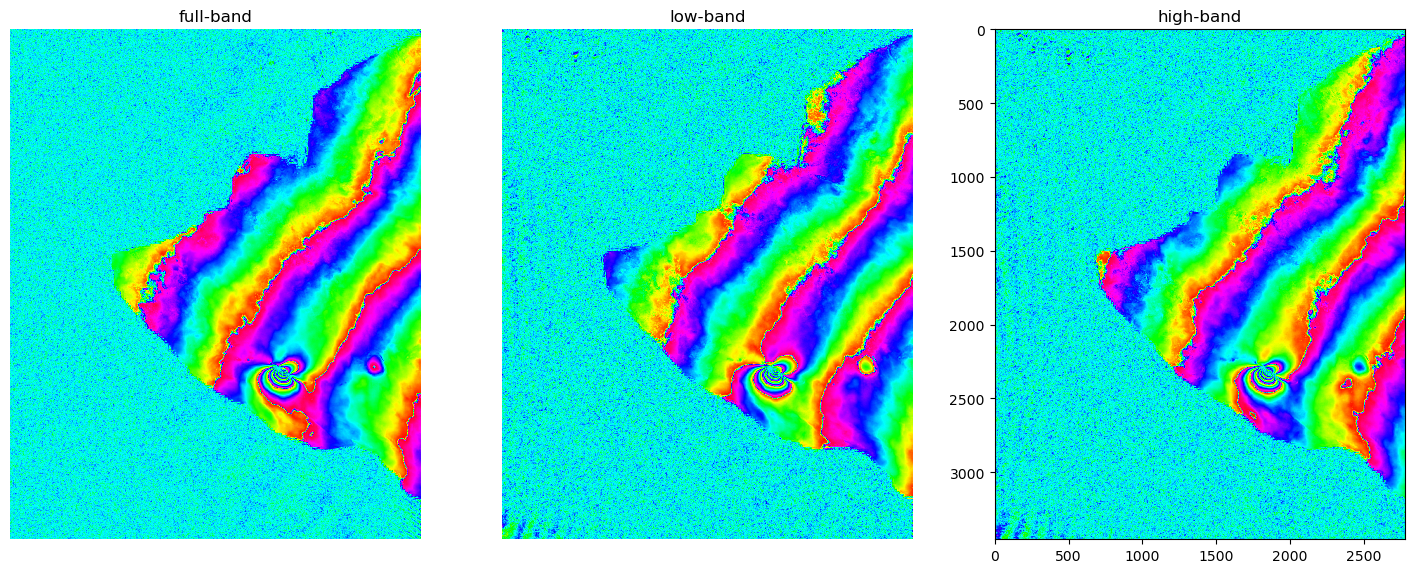

In [14]:
from osgeo import gdal
import matplotlib.pyplot as plt

ds = gdal.Open("interferogram/filt_topophase.flat", gdal.GA_ReadOnly)
igram_full_band = ds.GetRasterBand(1).ReadAsArray()
ds = None

ds = gdal.Open("interferogram/lowBand/filt_topophase.flat", gdal.GA_ReadOnly)
igram_low_band = ds.GetRasterBand(1).ReadAsArray()
ds = None

ds = gdal.Open("interferogram/highBand/filt_topophase.flat", gdal.GA_ReadOnly)
igram_high_band = ds.GetRasterBand(1).ReadAsArray()
ds = None

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
ax.imshow(np.angle(igram_full_band), cmap='hsv')
ax.set_title("full-band")
ax.set_axis_off()

ax = fig.add_subplot(1,3,2)
ax.imshow(np.angle(igram_low_band), cmap='hsv')
ax.set_title("low-band")
ax.set_axis_off()

ax = fig.add_subplot(1,3,3)
ax.imshow(np.angle(igram_high_band), cmap='hsv')
ax.set_title("high-band")
#ax.set_axis_off()


However, due to small difference between the center frequency of the sub-bands full-bands, there is small difference among the three interferograms. See the difference between the full-band and low-band interferograms:

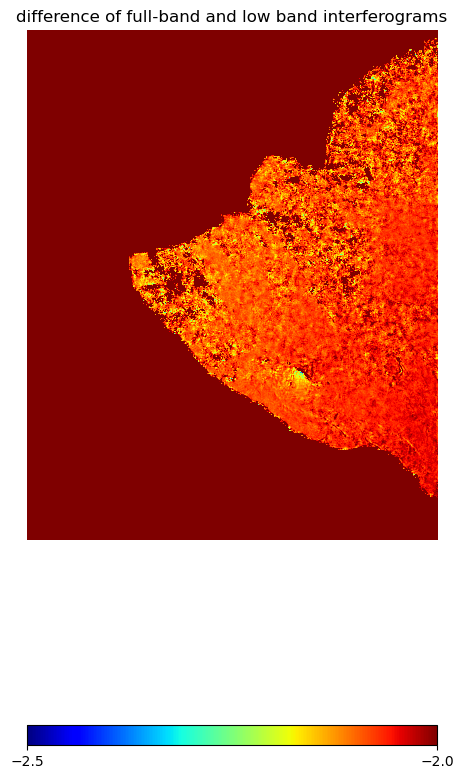

In [15]:
difference_full_low = igram_full_band*np.conjugate(igram_low_band)
fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
cax = ax.imshow(np.angle(difference_full_low), cmap='jet', vmin = -2.5, vmax =-2)
ax.set_title("difference of full-band and low band interferograms")
ax.set_axis_off()
cbar = fig.colorbar(cax, ticks=[-2.5,-2], orientation='horizontal')

igram_low_band = None
igram_full_band = None
igram_high_band = None
difference_full_low = None


### unwrap_low_band, unwrap_high_band

unwrap the full-band, low-band and high-band interferograms

In [16]:
!stripmapApp.py stripmapApp.xml --start=unwrap  --end=unwrap_high_band

2023-08-06 21:58:10,657 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-06 21:58:10,659 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-06 21:58:10,681 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step unwrap
GDAL open (R): interferogram/topophase.amp.vrt
GDAL open (R): interferogram/filt_topophase.flat.vrt
API open (WR): interferogram/filt_topophase.unw
API open (WR): interferogram/filt_topophase.conncomp

 << PS filtering >>


 interferogram width:  2781  number of lines/patch:  3656
 start line:        1  number of lines:    3456
 start sample:      1  end sample:         2781
 wisdomFile, length =            0

 << Unwrapping with icu, random trees 3-Nov-98 CW/PAR/SH >>

 Branch Cut Tree Type:           

### ionosphere

This step, uses the low-band and high-bamd unwrapped interferograms to estimate the dispersive and non-dispersive phase components. The disperive phase is related to the ionosphere's TEC variation.

In [17]:
!stripmapApp.py stripmapApp.xml --start=ionosphere --end=ionosphere

2023-08-06 22:01:32,346 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-06 22:01:32,347 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-06 22:01:32,371 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step ionosphere
incidence angle at the middle of the swath:  47.40596655633679
Ground range resolution at the middle of the swath:  14.544071121391305
imageMath.py -e="5.357070523636297e-08*(a_1*1274666416.7271395-(b_1+2.0*PI)*1265333083.393806)" --a=interferogram/lowBand/filt_topophase.unw --b=interferogram/highBand/filt_topophase.unw -o ionosphere/dispersive.bil -t float32 -s BIL
args:  Namespace(hh=None, equation='5.357070523636297e-08*(a_1*1274666416.7271395-(b_1+2.0*PI)*1265333083.393806)', out='ionosphere/dis

The following plot shows the estimated dispersive and non-dispersive phase components. 

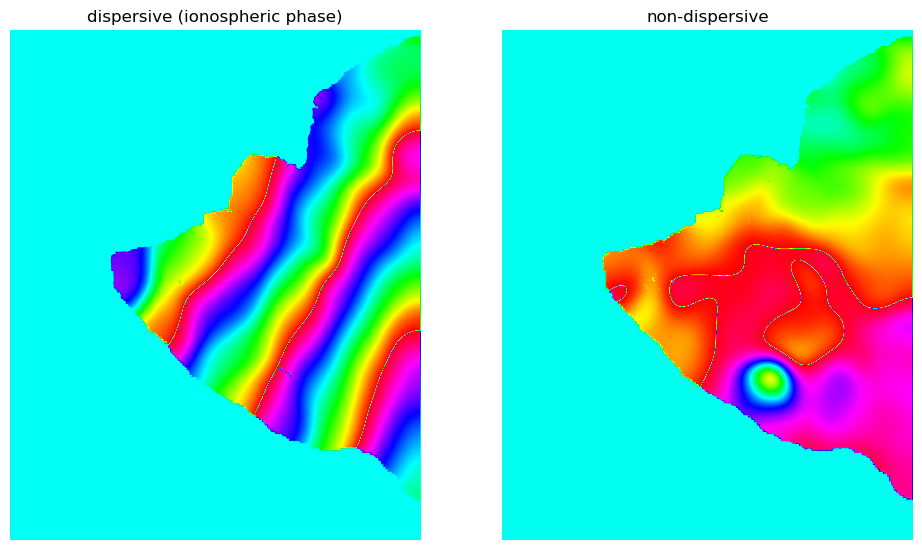

In [18]:
import matplotlib.pyplot as plt
def rewrap(data):
    return data-np.round(data/2./np.pi)*2*np.pi
    
    
ds = gdal.Open("ionosphere/dispersive.bil.filt", gdal.GA_ReadOnly)
iono = ds.GetRasterBand(1).ReadAsArray()
ds = None

ds = gdal.Open("ionosphere/nondispersive.bil.filt", gdal.GA_ReadOnly)
non_dispersive = ds.GetRasterBand(1).ReadAsArray()
ds = None

ds = gdal.Open("ionosphere/mask.bil", gdal.GA_ReadOnly)
mask = ds.GetRasterBand(1).ReadAsArray()
ds = None

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
ax.imshow(rewrap(iono)*mask, cmap='hsv')
ax.set_title("dispersive (ionospheric phase)")
ax.set_axis_off()

ax = fig.add_subplot(1,3,2)
ax.imshow(rewrap(non_dispersive)*mask, cmap='hsv')
ax.set_title("non-dispersive")
ax.set_axis_off()

iono = None
non_dispersive = None


<br>
<div class="alert alert-info">
<b>Note :</b> 
stripmapApp does not correct the interferogram for ionospheric phase. However, the corrected interferogram can be easily obtained by removing the estimated dispersive phase from the full-band interferogram. Below we do the subtraction in Python, but it can also be done from the command line with the ISCE2 `imageMath.py` application

</div>


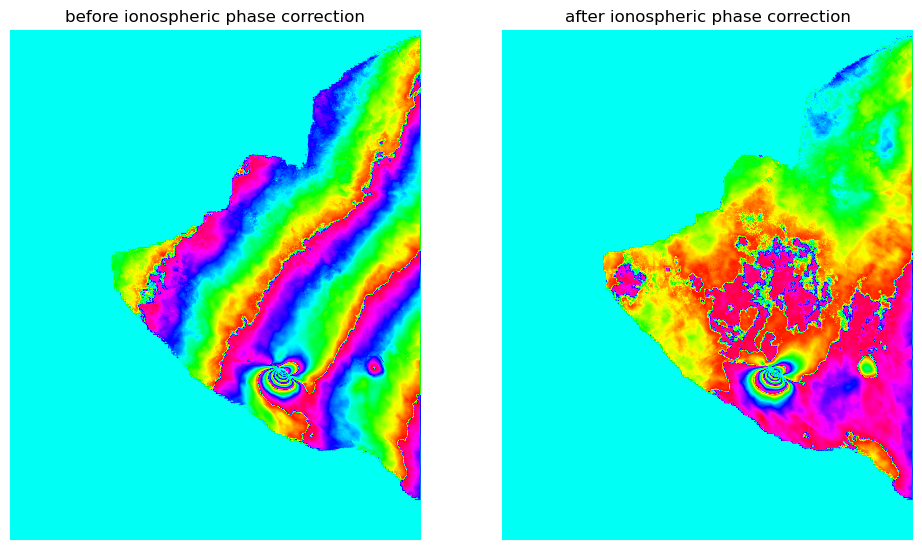

In [19]:
ds = gdal.Open("interferogram/filt_topophase.unw", gdal.GA_ReadOnly)
igram = ds.GetRasterBand(2).ReadAsArray()
ds = None

ds = gdal.Open("ionosphere/dispersive.bil.filt", gdal.GA_ReadOnly)
iono = ds.GetRasterBand(1).ReadAsArray()
ds = None

igram_iono_corrected = igram - iono

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(1,3,1)
ax.imshow(rewrap(igram), cmap='hsv')
ax.set_title("before ionospheric phase correction")
ax.set_axis_off()

ax = fig.add_subplot(1,3,2)
ax.imshow(rewrap(igram_iono_corrected)*mask, cmap='hsv')
ax.set_title("after ionospheric phase correction")
ax.set_axis_off()

iono = None
igram = None
igram_iono_corrected = None

### geocoding

By runing the geocode step, the interferogram, the dispersive phase and the mask in the ionosphere folder is geocoded. 

In [20]:
!stripmapApp.py stripmapApp.xml --start=geocode  --end=geocode

2023-08-06 22:02:10,596 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
2023-08-06 22:02:10,597 - root - INFO - reference sensor not provided explicitly, using common sensor
2023-08-06 22:02:10,621 - root - INFO - secondary sensor not provided explicitly, using common sensor
do_unwrap  True
Step processing
Running step geocode
2023-08-06 22:02:10,768 - isce.topsinsar.runGeocode - INFO - Geocoding Image
Number of products to geocode:  9
incidence angle at the middle of the swath:  47.40596655633679
Ground range resolution at the middle of the swath:  14.544071121391305
Polynomial Order: 0 - by - 2 
6.58238	-0.0102063	1.28408e-06	
Using native doppler information for bbox estimation
Polynomial Order: 0 - by - 2 
-7.44704	-0.00767223	9.40983e-07	
Using native doppler information for bbox estimation
Output:  interferogram/topoph

The follwoing plot comapres the geocoded interferogram before and after ionospheric phase estimation. 

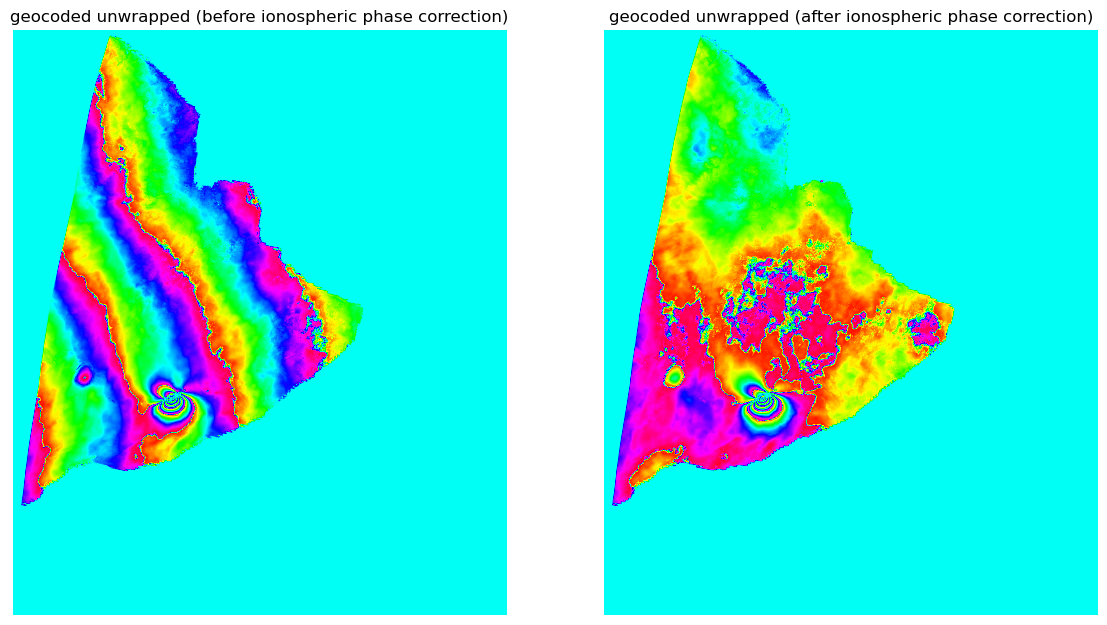

In [21]:
# reading the multi-looked wrapped interferogram
ds = gdal.Open("interferogram/filt_topophase.unw.geo", gdal.GA_ReadOnly)
igram = ds.GetRasterBand(2).ReadAsArray()
ds = None

ds = gdal.Open("ionosphere/dispersive.bil.unwCor.filt.geo", gdal.GA_ReadOnly)
iono = ds.GetRasterBand(1).ReadAsArray()
ds = None

ds = gdal.Open("ionosphere/mask.bil.geo", gdal.GA_ReadOnly)
mask = ds.GetRasterBand(1).ReadAsArray()
ds = None

igram_iono_corrected = (igram - iono)*mask

fig = plt.figure(figsize=(14,12))

ax = fig.add_subplot(1,2,1)

cax = ax.imshow(rewrap(igram), cmap = 'hsv')
ax.set_title("geocoded unwrapped (before ionospheric phase correction)")
ax.set_axis_off()

ax = fig.add_subplot(1,2,2)
cax = ax.imshow(rewrap(igram_iono_corrected), cmap = 'hsv')
ax.set_title("geocoded unwrapped (after ionospheric phase correction)")
ax.set_axis_off()

igram = None
iono = None
igram_iono_corrected = None
mask = None

# Supplementary information

### Low-pass filtering the estimated ionospheric phase

The estimated ionospheric phase from split range-spectrum method is usually noisy. Small decorrelation noise in sub-band interferograms amplifies significantly in the estimated ionospheric phase. Therefore low-pass filtering is usually necessary to reduce noise from the ionospheric noise. The default filter included in stripmapApp is an iterative low-pass filter with a gaussian kernel whose parameters can be controlled from the input xml file. 

```xml
<?xml version="1.0" encoding="UTF-8"?>
<stripmapApp>
  <component name="insar">
    <property name="sensor name">ALOS</property>
    <component name="reference">
        <catalog>reference.xml</catalog>
    </component>
    <component name="secondary">
        <catalog>secondary.xml</catalog>
    </component>

    <property name="demFilename">
        <value>demLat_N18_N21_Lon_W156_W154.dem.wgs84</value>
    </property>

    <property name="unwrapper name">icu</property>
    
    
    <property name="do dispersive">True</property>

    <property name="dispersive filter kernel x-size">800</property>
    <property name="dispersive filter kernel y-size">800</property>
    <property name="dispersive filter kernel sigma_x">100</property>
    <property name="dispersive filter kernel sigma_y">100</property>
    <property name="dispersive filter kernel rotation">0</property>
    <property name="dispersive filter number of iterations">5</property>
    <property name="dispersive filter mask type">coherence</property>
    <property name="dispersive filter coherence threshold">0.6</property>
      
</component>
</stripmapApp>
```

![title](docs_iono/Kernel.png)

### azimuth offsets induced by high ionospheric phase gradient

The Doppler frequency induced by high ionospheric phase gradient introduces an extra time shift (azimuth offset) which if not accounted for causes decorrelation. This effect only is observed when ionospheric phase has a spatially high frequency component usually caused by scintillation in the equatorial belt. stripmapApp allows to account for this extra azimuth shift using the optional step "rubber_sheet", which if turned on, extra azimuth shifts are computed using amplitude cross-correlation. Here is an example showing the impact of such ionospher's induced azimuth offsets on an L-band ALOS-1 interferogram in equatorial belt.

![title](docs_iono/AzOffsets.png)